##  Car Price Project - Preprocessing

### `Research Notes`

In [1]:
#KEY FEATURES
#price label, brand, model, age, horsepower/engine_type, mileage. time passage from ad post?

#SECONDARY FEATURES
#make, fuel type, mpg, exterior color, door number, transmission type,
#dimensions, safety, air condition, interior, navigation y/n, engine type
#cubic capacity, number of ad views, power steering, rim type
#registered city, number of doors, 4WD, damaged, leather, alarm,
#A/C, parking sensors, xenon lights, remote unlock, electric mirrors,
#seat heat, moon roof, cruise control, abs, traction control

#OTHER FEATURES
#estimated car life, price rank as category (cheap, moderate, expensive)

#Non-craigslist features
# gas price

#Sparse features to ignore?: damaged, city

In [2]:
#FEATURE ENHANCEMENT:
#Train with stratified sample of make
#Encode Thumbs Up/Down fields: [ON, OFF, NotAvailable] -> [1, -1, 0]
#Poly features for regression.  Ex. Mileage and year
#Differencing features and explicit features for orest.

In [3]:
# Candidate models
# Regression, KNN, SVM, random forest, naive bayes, neural networks
# Neural network should be best, followed by RF and SVM.

In [4]:
# Frame as Price as Regression vs Classification Problem
# Classification: bin continuous features using cluster analysis?

###  Imports

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import re
import pprint
import joblib

#pd.set_option('max_colwidth', 2000)
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

#Python iterators for efficient looping
import itertools

#transformers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

In [6]:
#This function will be used to combine json files scraped on different dates.  Deduping done separately.
def open_decode_json(json_file):
    '''Returns decoded json.  Read json and decode file into Python objects.
    read_file closed after with statement.'''
    import json
    with open(json_file, "r") as read_file:
        decoded = json.load(read_file)        
    return decoded

In [7]:
#Import data - austin, dallas, houston, and san antonio.  Pulled 11-18-2019.

austin=pd.read_json('json/austin_ford_2019-11-18.json')
dallas=pd.read_json('json/dallas_ford_2019-11-18.json')
ep=pd.read_json('json/ep_ford_2019-11-18.json')
houston=pd.read_json('json/houston_ford_2019-11-18.json')
sa=pd.read_json('json/sa_ford_2019_11_18.json')

print('Combined len:', len(austin) + len(dallas) + len(ep) + len(houston) + len(sa))

vehicle = pd.DataFrame()
for dframe in [austin, dallas, ep, houston, sa]:
    vehicle = vehicle.append(dframe, ignore_index = True)
display('vehicle:', vehicle.tail(1))

Combined len: 10538


'vehicle:'

,URL_Vehicle,Title,Price,SubLoc,Body,AttribDictionary,ImageDictionary
10537,https://sanantonio.craigslist.org/ctd/d/san-an...,2008 FORD F250 SUPER DUTY CREW CAB,$16900,(1200 basse rd San Antonio TX),"[\n , \n2008 FORD F250 SUPER DUTY CREW ...",{'0': '<span><b>2008 ford f-250 super duty cre...,{'0': 'https://images.craigslist.org/00k0k_9Lu...


In [8]:
#The vehicle 'Body' is a comma-delimited list.  Join list into a single string.
vehicle['Body'] = vehicle['Body'].str.join(',')

#Remove whitespace.  Replace blank entries with None.
vehicle['SubLoc'] = vehicle['SubLoc'].str.strip()
SubLoc_dict={'SubLoc': {np.nan : 'None'}}
vehicle.replace(SubLoc_dict, inplace=True)

In [9]:
#Drop TRUCKMAX autos that are outside Texas.  
vehicle[vehicle['SubLoc'] == '(TRUCKMAX)']
drop_indices = vehicle[vehicle['SubLoc'] == '(TRUCKMAX)'].index
print(f'Drop {len(drop_indices)} TRUCKMAX listings outside Texas:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Drop incomplete listing 5247.
vehicle.drop(labels = 5247, inplace = True, errors = 'ignore')

Drop 216 TRUCKMAX listings outside Texas: Int64Index([ 1955,  1956,  1958,  2083,  2085,  2120,  2121,  2275,  2277,
             2281,
            ...
             9867,  9901, 10065, 10069, 10093, 10143, 10202, 10209, 10386,
            10395],
           dtype='int64', length=216)


In [10]:
#Add feature columns and view dataframe
print('vehicle length:', len(vehicle))
print('vehicle type:', type(vehicle))
vehicle.insert(2,'Location',np.nan)
vehicle.insert(3,'Year',np.nan)
vehicle.insert(4,'Year_in_Title',np.nan)
vehicle.insert(5,'Odometer',np.nan)
vehicle.insert(6,'RawMake',np.nan)
vehicle.insert(7,'Make',np.nan)
vehicle.insert(8,'Model',np.nan)
vehicle.insert(9,'Trim',np.nan)
vehicle.insert(10,'Seller',np.nan)
vehicle.head(2)

vehicle length: 10321
vehicle type: <class 'pandas.core.frame.DataFrame'>


,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary
0,https://austin.craigslist.org/ctd/d/temple-201...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...


In [11]:
vehicle.loc[1,'AttribDictionary']

{'0': '<span><b>2006 Ford Focus SE</b></span>',
 '1': '<span>fuel: <b>gas</b></span>',
 '2': '<span>title status: <b>clean</b></span>',
 '3': '<span>transmission: <b>automatic</b></span>'}

In [12]:
def match_regex_patt(df, target_col, regex_patt, no_match_value='None'):
    '''Returns regex_patt matches as list.'''
    matchList=[]
    cnt = 0
    for idx in df.index:
        m = re.search(regex_patt, df.loc[idx, target_col], flags=re.IGNORECASE) #re.search(pattern, string) gets first match
        if m is not None:
            matchList.append(m.group(1).lower())
        else:
            cnt+=1
            matchList.append(no_match_value)
    print(f'In {target_col}, {cnt} missed matches for regex pattern: {regex_patt}.')
    return matchList
    
#Get VehicleID from URL_Vehicle.    
vehIDList = match_regex_patt(df=vehicle, target_col='URL_Vehicle', regex_patt=r'/(\d+)\.html', no_match_value='None')    
vehicle['VehicleID'] = vehIDList

#Get vehicle Location from URL location.craigslist.org
vehLocList = match_regex_patt(df=vehicle, target_col='URL_Vehicle', regex_patt='https://(.+)\.craigslist', no_match_value='None')    
vehicle['Location'] = vehLocList

In URL_Vehicle, 0 missed matches for regex pattern: /(\d+)\.html.
In URL_Vehicle, 0 missed matches for regex pattern: https://(.+)\.craigslist.


In [13]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID
0,https://austin.craigslist.org/ctd/d/temple-201...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",austin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...,7022706459
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,austin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...,7022331083


In [14]:
vehicle['AttribDictionary']

0        {'0': '<span><b>2016 FORD</b></span>', '1': '<...
1        {'0': '<span><b>2006 Ford Focus SE</b></span>'...
2        {'0': '<span><b>2004 FORD F450</b></span>', '1...
3        {'0': '<span><b>2007 FORD E350 SHUTTLE BUS</b>...
4        {'0': '<span><b>1979 1979 FORD MUSTANG</b></sp...
                               ...                        
10533    {'0': '<span><b>2013 Ford Explorer SUV</b></sp...
10534    {'0': '<span><b>2005 FORD E350</b></span>', '1...
10535    {'0': '<span><b>2014 Ford Mustang</b></span>',...
10536    {'0': '<span><b>2016 FORD</b></span>', '1': '<...
10537    {'0': '<span><b>2008 ford f-250 super duty cre...
Name: AttribDictionary, Length: 10321, dtype: object

In [15]:
#Build Year column from AttribDictionary.  Assert numeric format and none missing.
yrList=[]
for idx in vehicle.index:
    m = re.search(r'(\d+)', vehicle.loc[idx, 'AttribDictionary']['0'])  #re.search(pattern, string) gets first match
    yrList.append(m.group(1))  
vehicle['Year'] = yrList    
vehicle['Year'] = vehicle['Year'].astype('float').astype('int64')

#Keep Years 1999 and later.
print('Count of vehicles older than 1999 that were dropped:', sum(vehicle['Year'] < 1999))
filt = (vehicle['Year'] >= 1999)
vehicle = vehicle[filt]

assert vehicle['Year'].dtypes == 'int64',  "Year must be integer."
assert len(vehicle[vehicle['Year'].isna()]) == 0, "Year cannot have NAs."

Count of vehicles older than 1999 that were dropped: 594


In [16]:
#Extract Odometer and VIN from AttribDictionary.  For each index, go through dict keys.
odomet=[]
vin = []
vinCNT=0
for idx in vehicle.index:
    odo_success = 0
    vin_success = 0
    
    for k in vehicle.loc[idx, 'AttribDictionary'].keys():
        od_m = re.search(r'<span>odometer: <b>(\d+)</b>', vehicle.loc[idx, 'AttribDictionary'][str(k)]) #re.search(pattern, string) gets first match
        vin_m = re.search(r'<span>VIN: <b>(\w+)</b>', vehicle.loc[idx, 'AttribDictionary'][str(k)]) #re.search(pattern, string) gets first match
                
        if od_m is not None:
            odo_success = 1
            odomet.append(od_m.group(1))            
        if vin_m is not None:
            vin_success = 1
            vin.append(vin_m.group(1))
            
    if odo_success != 1:
        odomet.append(np.nan)        
    if vin_success != 1:
        vinCNT += 1
        vin.append('None'+str(vinCNT))  #Use None1, None2, None3 so each missing value is unique.

vehicle['Odometer'] = odomet
vehicle['Odometer'] = vehicle['Odometer'].astype('float')
vehicle['VIN'] = vin

In [17]:
vehicle.head(1)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN
0,https://austin.craigslist.org/ctd/d/temple-201...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",austin,2016,NaN,127.0,NaN,NaN,NaN,NaN,NaN,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...,7022706459,None1


In [18]:
vehicle[['URL_Vehicle','Body','Odometer']].head(10)

,URL_Vehicle,Body,Odometer
0,https://austin.craigslist.org/ctd/d/temple-201...,"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...",127.0
1,https://austin.craigslist.org/cto/d/red-rock-2...,"\n ,\n2006 Ford Focus in great mechanic...",NaN
2,https://austin.craigslist.org/cto/d/marble-fal...,"\n ,\nThis is a really nice dependable ...",100000.0
3,https://austin.craigslist.org/cto/d/marble-fal...,"\n ,\nThis is a really nice 9 Passenger...",130000.0
5,https://austin.craigslist.org/ctd/d/lockhart-2...,"\n ,\n,\n,\naddress: ,phone: ☎ ...",102467.0
6,https://austin.craigslist.org/ctd/d/manor-2019...,"\n ,\n\n,\n\n,\n\n,\n\n\n\n,\n\n,\n\n,\...",0.0
7,https://austin.craigslist.org/ctd/d/houston-20...,"\n ,\n,\n\n,We are dedicated to helping...",12820.0
8,https://austin.craigslist.org/ctd/d/austin-201...,"\n ,\n1000 down takes it.,7450 sales pr...",149000.0
9,https://austin.craigslist.org/ctd/d/manor-2013...,"\n ,\n\n,\n\n,\n\n,\n\n\n\n,\n\n,\n\n,\...",0.0
10,https://austin.craigslist.org/ctd/d/manor-2018...,"\n ,\n\n,\n\n,\n\n,\n\n\n\n,\n\n,\n\n,\...",0.0


In [19]:
#Mine Odometer alternative from Body.
odomAltList=r'((\d+,?\.?\d+)(K\s| miles))'
odomAltList = match_regex_patt(df=vehicle, target_col='Body', regex_patt=odomAltList, no_match_value=np.nan)    
vehicle['RawOdomAlt'] = odomAltList

In Body, 5968 missed matches for regex pattern: ((\d+,?\.?\d+)(K\s| miles)).


In [20]:
#Clean RawOdomAlt numbers.
vehicle['RawOdomAlt'] = vehicle['RawOdomAlt'].str.replace('[Kk]', '000').str.replace(',', '')\
                        .str.replace('.', '').str.replace('miles', '').str.strip()

#Set clean numbers less than 1,000 to np.nan.
vehicle['OdomAlt'] = vehicle['RawOdomAlt'].astype('float')
vehicle.loc[vehicle['OdomAlt'] < 1000, 'OdomAlt'] = np.nan

#Assign the OdomAlt value to NaN Odometer values.  Drop RawOdomAlt and OdomAlt.
vehicle.loc[vehicle['Odometer'].isna(), 'Odometer'] = vehicle.loc[vehicle['Odometer'].isna(), 'OdomAlt']
vehicle.drop(['RawOdomAlt', 'OdomAlt'], axis='columns', inplace=True, errors='igonre')

In [21]:
# pd.options.display.max_rows = 500
# vehicle.head(500)

In [22]:
#Create dealer/owner features using URL_vehicle.
vehicle['Seller']=vehicle['URL_Vehicle'].str.extract(r'(ct[o|d])')
vehicle['Seller']=vehicle['Seller'].str.replace('ctd', 'dealer')
vehicle['Seller']=vehicle['Seller'].str.replace('cto', 'owner')

In [23]:
#vehicle.to_csv('vehicle.csv')

In [24]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN
0,https://austin.craigslist.org/ctd/d/temple-201...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",austin,2016,NaN,127.0,NaN,NaN,NaN,NaN,dealer,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...,7022706459,None1
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,austin,2006,NaN,181000.0,NaN,NaN,NaN,NaN,owner,$3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...,7022331083,None2


In [25]:
#Extract RawMake col from AttribDictionary.
rawMakeList=[]
for idx in vehicle.index:
    m = re.search(r'<b>(.+)</b>', vehicle.loc[idx, 'AttribDictionary']['0']) #re.search(pattern, string) gets first match
    if m is not None:
        rawMakeList.append(m.group(1).lower())
    else:
        print('Missing Make/Model index:', idx)
        rawMakeList.append('None')
                 
vehicle['RawMake'] = rawMakeList

In [26]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN
0,https://austin.craigslist.org/ctd/d/temple-201...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",austin,2016,NaN,127.0,2016 ford,NaN,NaN,NaN,dealer,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...,7022706459,None1
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 ford focus se,NaN,NaN,NaN,owner,$3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...,7022331083,None2


In [27]:
#Populate Make
make_regex=r'(ford)\s'
makeList = match_regex_patt(df=vehicle, target_col='RawMake', regex_patt=make_regex, no_match_value='None')    
vehicle['Make'] = makeList

#Populate Model.  Search for ford + space + word + optional hyphen + NonWhiteSpace
model_regex=r'ford\s(\w+-{0,1}\S+)'
modelList = match_regex_patt(df=vehicle, target_col='RawMake', regex_patt=model_regex, no_match_value='None')    
vehicle['Model'] = modelList

#Populate Trim.  Search for ford + space + word + optional hyphen + NonWhiteSpace + space + word
trim_regex=r'ford\s\w+-{0,1}\S+\s(\w+)'
trimList = match_regex_patt(df=vehicle, target_col='RawMake', regex_patt=trim_regex, no_match_value='None')    
vehicle['Trim'] = trimList

#FIX scenario1: 'ford super duty myModel' issue.
model_regex2=r'ford\s\w+\s\w+\s(\w+-{0,1}\S+)'  #get word after 'ford super duty'
model_for_super_1st = match_regex_patt(df=vehicle, target_col='RawMake', regex_patt=model_regex2, no_match_value='None')
vehicle['Modelfix']=model_for_super_1st  #Use Modelfix for scenario1 vehicles only.

#Correct Trim, then Model.  Drop 'Modelfix' column.
vehicle.loc[vehicle['Model'] == 'super', 'Trim'] = 'super'
vehicle.loc[vehicle['Model'] == 'super', 'Model'] = vehicle.loc[vehicle['Model'] == 'super', 'Modelfix']
vehicle.drop(['Modelfix'], axis='columns', inplace = True, errors = 'ignore')

In RawMake, 104 missed matches for regex pattern: (ford)\s.
In RawMake, 144 missed matches for regex pattern: ford\s(\w+-{0,1}\S+).
In RawMake, 5982 missed matches for regex pattern: ford\s\w+-{0,1}\S+\s(\w+).
In RawMake, 7932 missed matches for regex pattern: ford\s\w+\s\w+\s(\w+-{0,1}\S+).


In [28]:
#Seach for trim + space/* in Title/Body.  Match starting alphanumeric character with class: [a-zA-Z0-9_].
#IMPORTANT: Try long keywords before short keywords -- leftmost tried first.

trimAltList=[]
valid_trim_patt=r'[,\.\s\*](convertible|commercial|commercial|flareside|hatchback|lightning|passenger|super\s?cab|super\s?crew|super\s?duty|supercrew|ecoboost|extended|heritage|platinum|supercab|titanium|bullitt|chassis|connect|cutaway|diesels|flatbed|hightop|limited|natural|premium|service|shuttle|utility|access|bucket|diesel|diesel|dually|energi|harley|hybrid|lariat|outlaw|raptor|saleen|shelby|sports|tremor|cargo|cobra|coupe|e-150|e-250|e-350|e-450|eddie|sport|super|t-250|t-350|turbo|wagon|base|boss|crew|dump|edge|king|mach|4+4|4x4|box|drw|ext|fwd|fx2|fx4|fx5|ltz|max|sel|srw|stx|xls|xlt|xl|zx3|zx4|gt|lx|rs|se|st|tx)[,\.\s\*]'

for idx in vehicle.index:
    m = re.search(valid_trim_patt, vehicle.loc[idx, 'Title'] + vehicle.loc[idx, 'Body'], flags=re.IGNORECASE) #re.search(pattern, string) gets first match
    if m is not None:
        trimAltList.append(m.group(1).lower())
    else:
        trimAltList.append('None')
                 
vehicle['TrimAlternate'] = trimAltList

#Assign Trim = 'None' rows to the TrimAlternate.
vehicle.loc[vehicle['Trim'] == 'None', 'Trim'] = vehicle.loc[vehicle['Trim'] == 'None', 'TrimAlternate']

In [29]:
vehicle.head(3)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,TrimAlternate
0,https://austin.craigslist.org/ctd/d/temple-201...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",austin,2016,NaN,127.0,2016 ford,None,None,xlt,dealer,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...,7022706459,None1,xlt
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 ford focus se,ford,focus,se,owner,$3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...,7022331083,None2,se
2,https://austin.craigslist.org/cto/d/marble-fal...,‘04 FORD F450 SERVICE TRUCK,austin,2004,NaN,100000.0,2004 ford f450,ford,f450,service,owner,$8950,(Marble Falls),"\n ,\nThis is a really nice dependable ...","{'0': '<span><b>2004 FORD F450</b></span>', '1...",{'0': 'https://images.craigslist.org/01717_30H...,7022347414,None3,service


In [30]:
arr=np.array([10,22,5,55])
lst=list(arr)
lst.count(22)

1

In [31]:
#Scrub Price - remove any $, periods, and spaces.  Note:  ORDER IS IMPORTANT!!!
#No raw string -- we want "\" to escape next character.
vehicle['Price']=vehicle['Price'].str.replace('\,', '')
vehicle['Price']=vehicle['Price'].str.replace('\.00', '')
vehicle['Price']=vehicle['Price'].str.replace('\.0', '')
vehicle['Price']=vehicle['Price'].str.replace('\$', '')
vehicle['Price']=vehicle['Price'].str.replace('-', '')
vehicle['Price']=vehicle['Price'].str.replace(' ', '')
vehicle['Price']=vehicle['Price'].str.replace('\.', 'None')

In [32]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,TrimAlternate
0,https://austin.craigslist.org/ctd/d/temple-201...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",austin,2016,NaN,127.0,2016 ford,None,None,xlt,dealer,34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...,7022706459,None1,xlt
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 ford focus se,ford,focus,se,owner,3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...,7022331083,None2,se


In [33]:
#Price is missing, None, or blank.  Drop corresponding rows.
filt = (vehicle['Price'].isna()) | (vehicle['Price'] == 'None') | (vehicle['Price'] == '')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} missing price rows:', drop_indices, '\n')
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Make isn't 'ford'.  Drop corresponding rows.
filt = (vehicle['Make'] != 'ford')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} non-ford makes:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Cast Price as float.
vehicle['Price'] = vehicle['Price'].astype('float')
assert len(vehicle[vehicle['Price'].isna()]) == 0, "Price cannot have NAs."

Drop 1180 missing price rows: Int64Index([   12,    15,    33,    44,    45,    46,    63,    64,    81,
               84,
            ...
            10438, 10471, 10472, 10481, 10491, 10493, 10499, 10505, 10518,
            10520],
           dtype='int64', length=1180) 

Drop 93 non-ford makes: Int64Index([    0,   164,   221,   257,   374,   452,   456,   489,   687,
              736,   783,   787,   869,   890,  1102,  1182,  1183,  1212,
             1303,  1464,  1554,  1558,  2167,  2199,  2296,  2366,  2482,
             2552,  2838,  2897,  2898,  3078,  4439,  4591,  4593,  4797,
             4885,  4919,  4941,  5043,  5083,  5084,  5101,  5102,  5164,
             5320,  5436,  5601,  5678,  5679,  5717,  5720,  5756,  6216,
             6839,  6883,  6941,  7007,  7096,  7135,  7137,  7185,  7255,
             7545,  7586,  7852,  8126,  8146,  8247,  8248,  8279,  8444,
             8586,  8590,  8606,  8905,  8924,  9197,  9327,  9413,  9422,
             9563,  9941,

In [34]:
#Flag invalid "DOWN/DP" prices by searching Title/SubLoc.  Drop "DOWN" prices under $5,001.  Cannot be "DOWNTOWN".
downList=[]
for idx in vehicle.index:
    m = re.search(r'(DP |DOWN)[^T]', vehicle.loc[idx, 'Title'] + vehicle.loc[idx, 'Body'] + vehicle.loc[idx, 'SubLoc'], flags=re.IGNORECASE) #re.search(pattern, string) gets first match
    if m is not None:
        downList.append('down')
    else:
        downList.append('None')
                 
vehicle['DownFlag'] = downList

filt = (vehicle['DownFlag'] == 'down') & (vehicle['Price'] < 5001)
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} DOWN prices under $5,001:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Drop $75,000+ prices.
filt2 = vehicle['Price'] > 74999
drop_indices = vehicle[filt2].index
print(f'Drop {len(drop_indices)} prices over $74,999:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

Drop 526 DOWN prices under $5,001: Int64Index([    8,    79,    88,   102,   141,   199,   200,   530,   696,
              733,
            ...
            10333, 10337, 10396, 10419, 10442, 10474, 10484, 10490, 10497,
            10526],
           dtype='int64', length=526)
Drop 14 prices over $74,999: Int64Index([ 597, 2162, 2908, 3481, 3823, 4018, 5638, 6418, 6702, 6798, 6799,
            7188, 7190, 8713],
           dtype='int64')


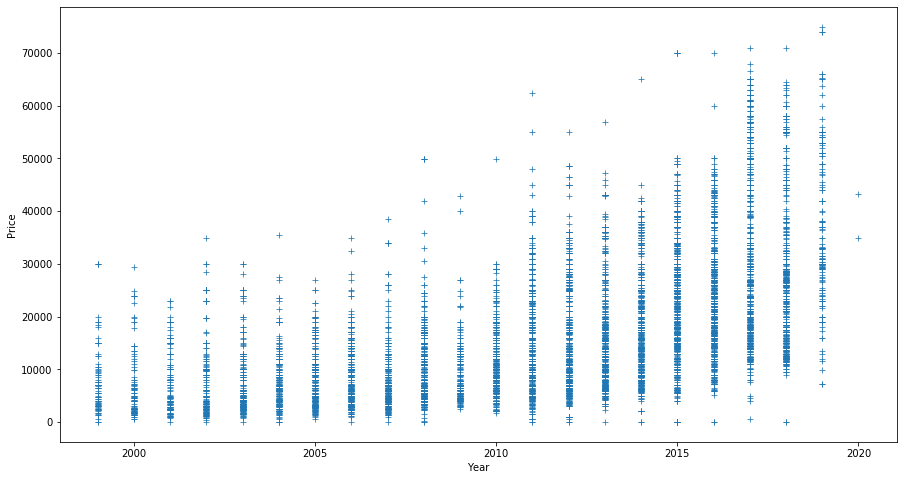

In [35]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='Year',y='Price', data=vehicle,  marker= '+')
plt.show()

In [36]:
#Fix Model names.
model_dict={
            'Model': {np.nan : 'None', 
                      '' : 'None',
                      'f150' : 'f-150',
                      'f250' : 'f-250', 
                      'f350' : 'f-350', 
                      'f450' : 'f-450'}
            }

vehicle.replace(model_dict, inplace=True)

#Fix Trim names.  LGB  and Ridge do best with NaN fix only.  Worse with spelling correction.
#And still worse with spelling and None corrections.
trim_dict={'Trim': {np.nan : 'None'}}

# trim_dict = {'Trim': {np.nan: 'None',
#                       'crewcab': 'crew',                      
#                       'deisel': 'diesel',
#                       'e150': 'e-150',
#                       'e250': 'e-250',
#                       'e350': 'e-350',
#                       'e450': 'e-450',
#                       'f550': 'f-550',                
#                       'harley-': 'harley',                
#                       'kingranch4x4crewdiesel': 'king',
#                       'passanger': 'passenger',
#                       'rapto': 'raptor',
#                       'super cab': 'super_cab',
#                       'supercab': 'super_cab',
#                       'super crew': 'super_crew',
#                       'supercrew': 'super_crew',
#                       'sd': 'super_duty',
#                       'super': 'super_duty',
#                       'súper': 'super_duty',
#                       'superduty': 'super_duty',
#                       'super duty': 'super_duty',
#                       'svt': 'raptor',
#                       'sxt': 'stx',
#                       't150': 't-150',
#                       't250': 't-250',
#                       'tit': 'titanium'}}

vehicle.replace(trim_dict, inplace=True)

In [37]:
# #View any dup VINs
# pd.options.display.max_rows = 999
# vehicle.groupby(['Location','Seller','VIN']).agg({'VIN': 'count'}).nlargest(600,'VIN')

In [38]:
#Drop Odometer=0.
odZeroFilt = (vehicle['Odometer'] == 0)
drop_indices = vehicle[odZeroFilt].index
print(f'#### Drop {len(drop_indices)} Odometer is zero miles:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

# #Drop duplicate VINs.  Over 60% of VINs are duplicates.  FIX OUTLIERS FIRST.
print('\n#### Duplicate VINs dropped:', vehicle.duplicated(subset=['VIN'], keep='first').sum())
vehicle.drop_duplicates(subset=['VIN'], inplace=True)

# #Drop vehicles with duplicate Title/Odometer/Price.
print('\n#### Duplicate Vehicles dropped:', vehicle.duplicated(subset=['Title', 'Odometer', 'Price'], keep='first').sum())
vehicle.drop_duplicates(subset=['Title', 'Odometer', 'Price'], inplace=True)

#### Drop 16 Odometer is zero miles: Int64Index([   6,    9,   10,  178,  573, 1338, 1414, 1415, 1449, 1450, 2189,
            5072, 6073, 7020, 8619, 8655],
           dtype='int64')

#### Duplicate VINs dropped: 1326

#### Duplicate Vehicles dropped: 622


In [39]:
len(vehicle)

5950

**** No LightGBM improvement from LN transform of price.  Linear models improve. ****


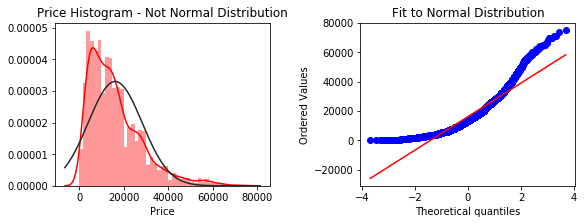

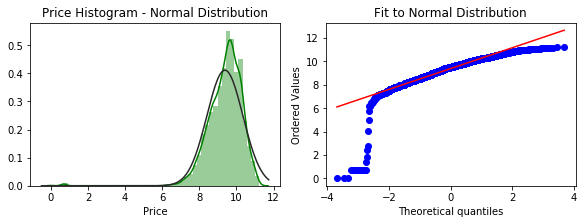

In [40]:
from scipy import stats
from scipy.stats import norm

def normalize_feature(df, bad_feature):
    
    #Make histogram & normal probability plot
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3),constrained_layout=True)
    sns.distplot(df[bad_feature], color='r', fit=stats.norm, ax=ax1)
    ax1.set_title(f'{bad_feature} Histogram - Not Normal Distribution')
    res=stats.probplot(df[bad_feature], dist='norm', plot=ax2)
    ax2.set_title('Fit to Normal Distribution')

    #Normalize with log (x+1).  Log of skewed feature: log e(feature+1)=normFeat
    #Exponential equation to undo normpr: e^normFeat-1=feature
    log_feat=np.log(df[bad_feature]+1)
        
    #Plots after normalization
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3),constrained_layout=True)
    sns.distplot(log_feat, color='g', fit=norm, ax=ax1)
    ax1.set_title(bad_feature+' Histogram - Normal Distribution')
    res=stats.probplot(log_feat, dist='norm', plot=ax2)
    ax2.set_title('Fit to Normal Distribution')
    return log_feat

vehicle['LN_Price'] = normalize_feature(df=vehicle, bad_feature='Price')
print('**** No LightGBM improvement from LN transform of price.  Linear models improve. ****')

In [41]:
#Flag outliers at designated year.
def flag_outliers(df, filt_col, filt_col_val, col_to_flag):
    ''' Flag anomolies for target col_to_flag and filt_col_val.'''
    filtSer=df.loc[df[filt_col] == filt_col_val, col_to_flag].copy()
    three_std = 3 * filtSer.std()
    avg = filtSer.mean()
    lower_lim = avg - three_std
    upper_lim = avg + three_std
    print(' average:', round(avg,1), '\n', 'lower_lim:', round(lower_lim,1), '\n', 'upper_lim:', round(upper_lim,1))
    
    outside_lim=[]
    for idx in filtSer.index:      
        price = filtSer.loc[idx]        
        if price > upper_lim or price < lower_lim:
            outside_lim.append([idx, col_to_flag, price])     
    return outside_lim

outs_lim = flag_outliers(df=vehicle, filt_col='Year', filt_col_val=2014, col_to_flag='Price')        
display(outs_lim)

 average: 17334.8 
 lower_lim: -9991.2 
 upper_lim: 44660.8


[[258, 'Price', 65000.0], [8377, 'Price', 45000.0]]

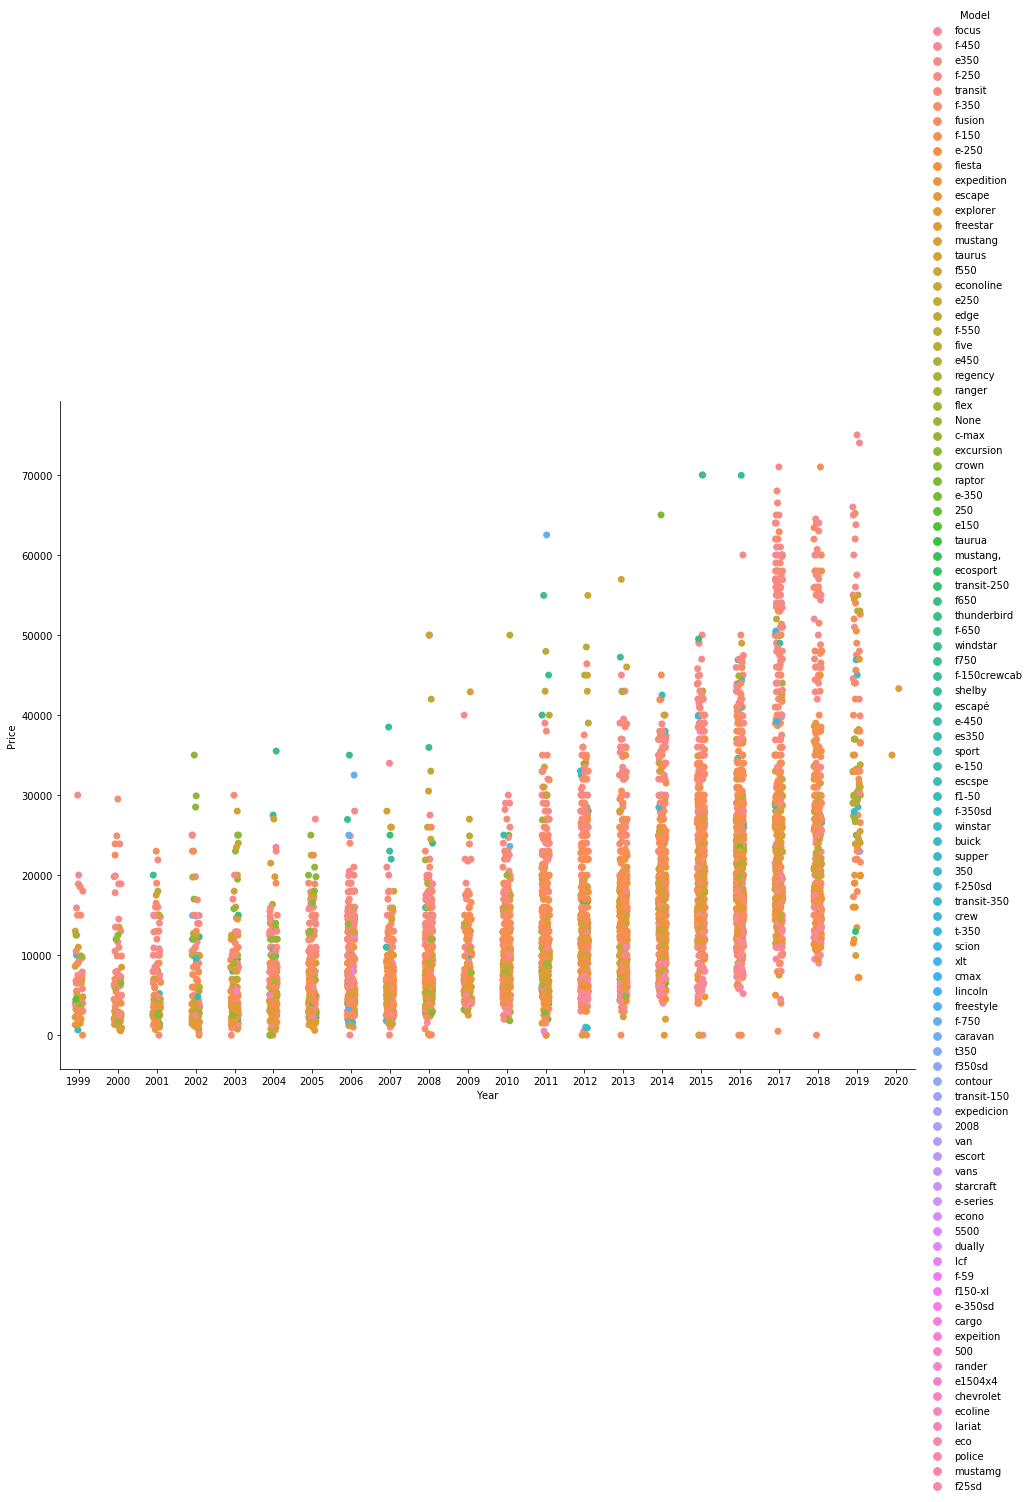

In [42]:
#Catplot by Year, Price, and Model
sns.catplot(x='Year',y='Price',hue='Model', data=vehicle, height=10, aspect=1.3, s=7)  #s changes marker size
plt.show()

In [43]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,TrimAlternate,DownFlag,LN_Price
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 ford focus se,ford,focus,se,owner,3000.0,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...,7022331083,None2,se,None,8.006701
2,https://austin.craigslist.org/cto/d/marble-fal...,‘04 FORD F450 SERVICE TRUCK,austin,2004,NaN,100000.0,2004 ford f450,ford,f-450,service,owner,8950.0,(Marble Falls),"\n ,\nThis is a really nice dependable ...","{'0': '<span><b>2004 FORD F450</b></span>', '1...",{'0': 'https://images.craigslist.org/01717_30H...,7022347414,None3,service,None,9.099521


In [44]:
#Engineer vehicle features Part 1.  Get category feature pairs.

#Temporarily convert Year to category/str.  Adding Year improves regression MAE by 20% but only 0.4% for lgb.
#vehicle['Year'] = vehicle['Year'].apply(str)

cat_feat=['Model', 'Trim', 'Seller']
pairs = list(itertools.combinations(cat_feat,2))
for tup in pairs:
    print(tup)
    vehicle[tup[0] + '_' + tup[1]] = vehicle[tup[0]] + '_' + vehicle[tup[1]]
        
#Convert Year back to integer
#vehicle['Year'] = vehicle['Year'].astype('float').astype('int64')

('Model', 'Trim')
('Model', 'Seller')
('Trim', 'Seller')


### Drop rare Models and Trims (Lowers Dimensionality)

In [45]:
#Remove vehicle 'Model' is None.
filt = (vehicle['Model'] == 'None')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} Models that are "None":', drop_indices)
vehicle = vehicle.drop(index = drop_indices, errors = 'ignore')

#Remove vehicle 'Trim' is None.
filt2 = (vehicle['Trim'] == 'None')
drop_indices2 = vehicle[filt2].index
print(f'Drop {len(drop_indices2)} Trims that are "None":', drop_indices2)
vehicle = vehicle.drop(index = drop_indices2, errors = 'ignore')

#Remove vehicle 'Model' counts under 50.
model_counts=vehicle['Model'].value_counts()             #get freq
print('\nDropping models with less than 50 examples:', model_counts[model_counts < 50].index)
models_over_50 = model_counts[model_counts >= 50].index  #get 50+ model names
vehicle= vehicle[vehicle['Model'].isin(models_over_50)] #boolean filter for the 50+ model names
print('\nOver 50 example models:\n', vehicle['Model'].value_counts())

#Remove vehicle 'Trim' counts under threshold.
thresh=50
trim_counts=vehicle['Trim'].value_counts()             #get freq
print(f'\nDropping trim with less than {thresh}examples:', trim_counts[trim_counts < thresh].index)
trim_over_thresh = trim_counts[trim_counts >= thresh].index  #get thresh+ trim names
vehicle= vehicle[vehicle['Trim'].isin(trim_over_thresh)] #boolean filter for the thresh+ trim names
print(f'\nOver {thresh} example trims:\n', vehicle['Trim'].value_counts())

Drop 22 Models that are "None": Int64Index([  211,   805,  1023,  1614,  2567,  3182,  3373,  3586,  4606,
             5385,  5783,  6031,  7346,  7925,  8006,  9032,  9505,  9705,
             9863,  9882, 10091, 10237],
           dtype='int64')
Drop 477 Trims that are "None": Int64Index([   52,    73,    74,    90,   135,   138,   139,   148,   183,
              219,
            ...
            10073, 10102, 10207, 10288, 10349, 10382, 10398, 10463, 10516,
            10531],
           dtype='int64', length=477)

Dropping models with less than 50 examples: Index(['f550', 'econoline', 'f-550', 'excursion', 'crown', 'e250', 'flex',
       'e450', 'e-350', 'e150', 'c-max', 'five', 'f-250sd', 'f750', 'f650',
       'shelby', 'e-250', 'thunderbird', 'windstar', 'e-450', 'f-650', 'f-750',
       'e-150', 'transit-350', 'f-350sd', 'freestar', 'e-series', 'freestyle',
       'ecosport', 'raptor', '250', 'transit-250', 'starcraft', 't350', '350',
       'sport', 'lariat', 'cmax', '2008', 

In [46]:
vehicle.head(1)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,TrimAlternate,DownFlag,LN_Price,Model_Trim,Model_Seller,Trim_Seller
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 ford focus se,ford,focus,se,owner,3000.0,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...,7022331083,None2,se,None,8.006701,focus_se,focus_owner,se_owner


## Get train and test, stratified by Model.

In [47]:
#Build train and test from vehicle.  Stratify by Model.
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=22)
for train_index, test_index in sss.split(vehicle, vehicle['Model']):
    train = vehicle.iloc[train_index]
    test = vehicle.iloc[test_index]

In [48]:
train.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,TrimAlternate,DownFlag,LN_Price,Model_Trim,Model_Seller,Trim_Seller
4420,https://dallas.craigslist.org/ftw/ctd/d/lillia...,2010 Ford Fusion 70k miles *CLEAN*,dallas,2010,NaN,70052.0,2010 ford fusion,ford,fusion,super,dealer,4800.0,(Mansfield/Burleson),"\n ,\n2010 Ford Fusion...70,052 miles.....","{'0': '<span><b>2010 ford fusion</b></span>', ...",{'0': 'https://images.craigslist.org/00b0b_5wv...,7021875312,None1847,super,None,8.476580,fusion_super,fusion_dealer,super_dealer
7169,https://houston.craigslist.org/ctd/d/houston-2...,2018 Ford Escape SEL 4x4 4WD Four Wheel Drive ...,houston,2018,NaN,7800.0,2018 ford escape,ford,escape,sel,dealer,20991.0,(Please call *281-612-3760* to Confirm Availab...,"\n ,\n, You can immediately confirm ava...","{'0': '<span><b>2018 Ford Escape</b></span>', ...",{'0': 'https://images.craigslist.org/01111_5VZ...,7015900753,None3078,sel,down,9.951897,escape_sel,escape_dealer,sel_dealer


In [49]:
#DROP IRRELEVANT COLUMNS.
irrel_cols = ['URL_Vehicle', 'Title', 'Year_in_Title', 'RawMake', 'SubLoc', 'Body', 'AttribDictionary', 
                    'ImageDictionary', 'VehicleID', 'VIN', 'TrimAlternate', 'DownFlag', 'LN_Price']

train = train.drop(irrel_cols, axis='columns', errors='ignore')
test = test.drop(irrel_cols, axis='columns', errors='ignore')

In [50]:
def impute_nan_by_categ(train_df, test_df, cat_col1, cat_col2, stat_col, stat_calc = 'median'):
    ''' Using train, get dictionary entry for each cat_col 1-2 group:
        {'group': {'stat_col': value}}.  Replace nan with train value in 
        both train and test.  This avoids data leakage.  Return  updated
        train and test dataframes.'''
    
    trn = train_df.copy()
    tst = test_df.copy()
    trnDict=trn.groupby([cat_col1, cat_col2]).agg({stat_col : stat_calc}).to_dict('index')
    trnDict_fallback=trn.groupby([cat_col1]).agg({stat_col : stat_calc}).to_dict('index')
    print(f'Made dictionary of {stat_calc} {stat_col} value by {cat_col1}-{cat_col2}. Fallback by {cat_col1}.\n')
        
    for k in trnDict.keys():  #scrub by Year-Model
        filtTrain = (trn[cat_col1] == k[0]) & (trn[cat_col2] == k[1]) & (trn[stat_col].isna())
        filtTest = (tst[cat_col1] == k[0]) & (tst[cat_col2] == k[1]) & (tst[stat_col].isna())
        val = trnDict[k][stat_col]
        fallback_val = trnDict_fallback[k[0]][stat_col]
        
        if np.isnan(val):  #if Year-Model missing, use Year fallback.
            print(f'Used {cat_col1} fallback for {cat_col1}-{cat_col2}: {k}. Train count: {len(trn.loc[filtTrain, stat_col])}. Test count: {len(tst.loc[filtTest, stat_col])}')
            trn.loc[filtTrain, stat_col] = fallback_val
            tst.loc[filtTest, stat_col] = fallback_val
        else:
            trn.loc[filtTrain, stat_col] = val
            tst.loc[filtTest, stat_col] = val            
            
    for key in trnDict_fallback.keys():    #scrub the missed Model-Year combos in test with Model-only fallback.
        filtTestCatCol1 = (tst[cat_col1] == key) & (tst[stat_col].isna())
        catCol1_val = trnDict_fallback[key][stat_col]
        tst.loc[filtTestCatCol1, stat_col] = catCol1_val
        
    return trn, tst, trnDict, trnDict_fallback

#Update NaNs with median odometer value by Model-Year.
train, test, trnDict, trnDict_fallback = impute_nan_by_categ(train_df=train, test_df=test, cat_col1='Year', cat_col2='Model', stat_col='Odometer')  

Made dictionary of median Odometer value by Year-Model. Fallback by Year.

Used Year fallback for Year-Model: (2000, 'taurus'). Train count: 1. Test count: 0
Used Year fallback for Year-Model: (2001, 'e350'). Train count: 1. Test count: 0
Used Year fallback for Year-Model: (2002, 'focus'). Train count: 1. Test count: 0
Used Year fallback for Year-Model: (2004, 'escape'). Train count: 2. Test count: 0
Used Year fallback for Year-Model: (2005, 'f-450'). Train count: 1. Test count: 0
Used Year fallback for Year-Model: (2006, 'fusion'). Train count: 1. Test count: 0


In [51]:
#Correct odometer values that are understated.
filt_under_1K = train['Odometer'] < 1000
train.loc[filt_under_1K, 'Odometer'] = train.loc[filt_under_1K, 'Odometer'] * 1000

filt_under_1K = test['Odometer'] < 1000
test.loc[filt_under_1K, 'Odometer'] = test.loc[filt_under_1K, 'Odometer'] * 1000

#Correct odometer values that are overstated.
filt_over_1M = train['Odometer'] > 1_000_000
train.loc[filt_over_1M, 'Odometer'] = train.loc[filt_over_1M, 'Odometer'] / 1000

filt_over_1M = test['Odometer'] > 1_000_000
test.loc[filt_over_1M, 'Odometer'] = test.loc[filt_over_1M, 'Odometer'] / 1000

In [52]:
#Engineer features Part 2.
def get_polyfeatures(train, target, numer_cols, degree=5):
    '''
    Returns top train feature correlations as DataFrame.
    '''
    from sklearn.preprocessing import PolynomialFeatures
    poly=PolynomialFeatures(degree=degree, interaction_only=False, include_bias=False)    
    ptrn = train[numer_cols].copy()
    orig_cols = set(ptrn.columns.values)
    ptrn=pd.DataFrame(data=poly.fit_transform(ptrn),index=train.index,columns=poly.get_feature_names(input_features=numer_cols))
    final_cols = set(ptrn.columns.values)
    added_cols = final_cols - orig_cols
    print('Poly columns:', added_cols, '\n')
            
    #Get top correlation dataframe and top features list. 
    corrList = [[c, np.corrcoef(ptrn[c].values, train[target].values)[1,0]] for c in ptrn.columns]
    corrtrn=pd.DataFrame(data=corrList, columns=['feature','PriceCorr']).sort_values(by='PriceCorr', ascending=False).dropna().reset_index(drop=True)
    print('train correlations:\n\n', corrtrn)
    return ptrn[added_cols]  

num_feat=[col for col in train.select_dtypes(exclude='object').columns];
num_feat.remove('Price');

#Get poly feature dataframe.
p_added = get_polyfeatures(train=train, target='Price', numer_cols=num_feat, degree=2)

#Add certain poly features to train and test
train['Year^2'] = train['Year']**2
train['Year_Odometer'] = train['Year'] * train['Odometer']
train['LN_Odometer'] = np.log(train['Odometer'])

test['Year^2'] = test['Year']**2
test['Year_Odometer'] = test['Year'] * test['Odometer']
test['LN_Odometer'] = np.log(test['Odometer'])

Poly columns: {'Year^2', 'Odometer^2', 'Year Odometer'} 

train correlations:

          feature  PriceCorr
0         Year^2   0.584843
1           Year   0.584584
2     Odometer^2  -0.286927
3  Year Odometer  -0.405857
4       Odometer  -0.407091


In [53]:
# plt.figure(figsize=(14,12))
# sns.scatterplot(x='LN_Odometer', y='Price', data=train)
# plt.show()

In [54]:
#Create numeric version of train for pairplotting.
train2=train.copy()
print(train2.dtypes)
display(train2.head(2))

from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

for col in train2.select_dtypes('object').columns.values:  #Encode categoricals as ordinal
    train2[col] = le.fit_transform(train2[col].tolist())
display(train2.head(3))

Location          object
Year               int64
Odometer         float64
Make              object
Model             object
Trim              object
Seller            object
Price            float64
Model_Trim        object
Model_Seller      object
Trim_Seller       object
Year^2             int64
Year_Odometer    float64
LN_Odometer      float64
dtype: object


,Location,Year,Odometer,Make,Model,Trim,Seller,Price,Model_Trim,Model_Seller,Trim_Seller,Year^2,Year_Odometer,LN_Odometer
4420,dallas,2010,70052.0,ford,fusion,super,dealer,4800.0,fusion_super,fusion_dealer,super_dealer,4040100,140804520.0,11.156993
7169,houston,2018,7800.0,ford,escape,sel,dealer,20991.0,escape_sel,escape_dealer,sel_dealer,4072324,15740400.0,8.961879


,Location,Year,Odometer,Make,Model,Trim,Seller,Price,Model_Trim,Model_Seller,Trim_Seller,Year^2,Year_Odometer,LN_Odometer
4420,1,2010,70052.0,0,11,16,0,4800.0,100,21,34,4040100,140804520.0,11.156993
7169,3,2018,7800.0,0,2,14,0,20991.0,12,3,28,4072324,15740400.0,8.961879
8458,4,2016,104000.0,0,11,20,0,12900.0,101,21,40,4064256,209664000.0,11.552146


In [55]:
#train2 correlations
train2Corr = [[c, np.corrcoef(train2[c].values, train2['Price'].values)[1,0]] for c in train2.columns]
train2Corr

C:\Users\Justin\Anaconda3\envs\tensorflow\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Justin\Anaconda3\envs\tensorflow\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


[['Location', 0.01518320323388781],
 ['Year', 0.5845840460427754],
 ['Odometer', -0.40709052644612276],
 ['Make', nan],
 ['Model', -0.08934966245797506],
 ['Trim', 0.07031855028669212],
 ['Seller', -0.2982268648743801],
 ['Price', 1.0],
 ['Model_Trim', -0.03342326490242908],
 ['Model_Seller', -0.10885387199399586],
 ['Trim_Seller', 0.05622014605411222],
 ['Year^2', 0.5848425301603436],
 ['Year_Odometer', -0.4058570629270066],
 ['LN_Odometer', -0.41757792948188266]]

In [56]:
#Investigate outliers revealed in pairplot.
# sns.set(font_scale=1.5)
# sns.pairplot(train2)
# plt.show()

In [57]:
#Get numeric train correlations
train2.corr()['Price'].sort_values(ascending=False)

Price            1.000000
Year^2           0.584843
Year             0.584584
Trim             0.070319
Trim_Seller      0.056220
Location         0.015183
Model_Trim      -0.033423
Model           -0.089350
Model_Seller    -0.108854
Seller          -0.298227
Year_Odometer   -0.405857
Odometer        -0.407091
LN_Odometer     -0.417578
Make                  NaN
Name: Price, dtype: float64

### Save Preprocessed data - train and test

In [58]:
joblib.dump(train, 'trainClean.joblib')
joblib.dump(test, 'testClean.joblib')
joblib.dump(vehicle, 'vehicle.joblib', compress=2)

['vehicle.joblib']

In [59]:
print('train shape:', train.shape, '| test shape:', test.shape)

train shape: (3604, 14) | test shape: (401, 14)


In [60]:
train.Trim.value_counts()

xlt           557
super         485
se            470
lariat        248
supercrew     198
gt            195
super duty    183
limited       136
edge          116
xl            110
sel           101
4x4            97
king           92
titanium       85
platinum       69
sport          69
fx4            67
crew           63
eddie          60
ecoboost       59
connect        51
supercab       48
diesel         45
Name: Trim, dtype: int64